In [1]:
import os
import random
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_WAY = 2
K_SHOT = 10
Q_QUERY = 5
IMAGE_SIZE = 224


d:\skripsi firman\Ayu\Ayu\211210051_Project Data Mining\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SkinCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_images = {}
        self.classes = sorted(os.listdir(root_dir))

        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            images = [os.path.join(cls_path, img) for img in os.listdir(cls_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            self.class_to_images[cls] = images

    def sample_episode(self, n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY):
        selected_classes = random.sample(self.classes, n_way)
        support_images, support_labels = [], []
        query_images, query_labels = [], []

        for idx, cls in enumerate(selected_classes):
            images = random.sample(self.class_to_images[cls], k_shot + q_query)
            support = images[:k_shot]
            query = images[k_shot:]

            support_images.extend(support)
            support_labels.extend([idx] * k_shot)
            query_images.extend(query)
            query_labels.extend([idx] * q_query)

        return support_images, support_labels, query_images, query_labels

    def load_images(self, paths):
        imgs = []
        for path in paths:
            img = np.array(Image.open(path).convert('RGB'))
            if self.transform:
                img = self.transform(image=img)['image']
            imgs.append(img)
        return torch.stack(imgs)


In [3]:
transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])


d:\skripsi firman\Ayu\Ayu\211210051_Project Data Mining\env\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
class EfficientNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        self.mlp = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 256)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.mlp(x)


In [5]:
def euclidean_dist(a, b):
    n = a.shape[0]
    m = b.shape[0]
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    return torch.pow(a - b, 2).sum(2)

def compute_prototypes(support_emb, support_labels, n_way, k_shot):
    prototypes = []
    for c in range(n_way):
        idxs = [i for i, label in enumerate(support_labels) if label == c]
        cls_embed = support_emb[idxs]
        prototype = cls_embed.mean(0)
        prototypes.append(prototype)
    return torch.stack(prototypes)


In [6]:
def train_few_shot(model, dataset, episodes=100):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    for episode in range(episodes):
        support_paths, support_labels, query_paths, query_labels = dataset.sample_episode()
        support_imgs = dataset.load_images(support_paths).to(DEVICE)
        query_imgs = dataset.load_images(query_paths).to(DEVICE)

        support_emb = model(support_imgs)
        query_emb = model(query_imgs)

        prototypes = compute_prototypes(support_emb, support_labels, N_WAY, K_SHOT)
        dists = euclidean_dist(query_emb, prototypes)
        preds = torch.argmin(dists, dim=1)

        loss = loss_fn(-dists, torch.tensor(query_labels).to(DEVICE))
        acc = (preds.cpu().numpy() == np.array(query_labels)).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"[Episode {episode+1}] Loss: {loss.item():.4f} | Acc: {acc:.4f}")


In [7]:
def evaluate_and_metrics(model, dataset, episodes=50):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for _ in range(episodes):
            s_paths, s_labels, q_paths, q_labels = dataset.sample_episode()
            s_imgs = dataset.load_images(s_paths).to(DEVICE)
            q_imgs = dataset.load_images(q_paths).to(DEVICE)

            s_emb = model(s_imgs)
            q_emb = model(q_imgs)

            protos = compute_prototypes(s_emb, s_labels, N_WAY, K_SHOT)
            dists = euclidean_dist(q_emb, protos)

            probs = torch.softmax(-dists, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(q_labels)
            all_probs.extend(probs[:, 1].cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", cm)

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

    if N_WAY == 2:
        auc = roc_auc_score(y_true, y_prob)
        print(f"ROC AUC: {auc:.4f}")
        fpr, tpr, _ = roc_curve(y_true, y_prob)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color="blue")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()
    
    return y_true, y_pred, y_prob



[Episode 1] Loss: 0.6436 | Acc: 0.9000
[Episode 2] Loss: 0.6782 | Acc: 0.7000
[Episode 3] Loss: 0.7079 | Acc: 0.5000
[Episode 4] Loss: 0.6630 | Acc: 0.5000
[Episode 5] Loss: 0.6217 | Acc: 0.9000
[Episode 6] Loss: 0.6632 | Acc: 0.8000
[Episode 7] Loss: 0.5297 | Acc: 0.8000
[Episode 8] Loss: 0.6131 | Acc: 1.0000
[Episode 9] Loss: 0.5917 | Acc: 0.7000
[Episode 10] Loss: 0.6479 | Acc: 0.5000
[Episode 11] Loss: 0.4893 | Acc: 0.7000
[Episode 12] Loss: 0.5102 | Acc: 0.9000
[Episode 13] Loss: 0.2851 | Acc: 1.0000
[Episode 14] Loss: 0.2759 | Acc: 1.0000
[Episode 15] Loss: 0.6825 | Acc: 0.7000
[Episode 16] Loss: 0.1871 | Acc: 1.0000
[Episode 17] Loss: 0.5783 | Acc: 0.6000
[Episode 18] Loss: 0.2963 | Acc: 0.9000
[Episode 19] Loss: 0.5560 | Acc: 0.8000
[Episode 20] Loss: 0.1523 | Acc: 0.9000
[Episode 21] Loss: 0.2497 | Acc: 0.9000
[Episode 22] Loss: 0.5858 | Acc: 0.8000
[Episode 23] Loss: 0.1024 | Acc: 1.0000
[Episode 24] Loss: 0.2503 | Acc: 0.8000
[Episode 25] Loss: 0.1000 | Acc: 0.9000
[Episode 

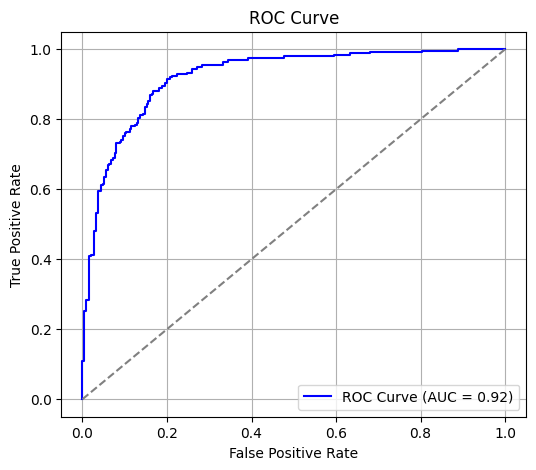

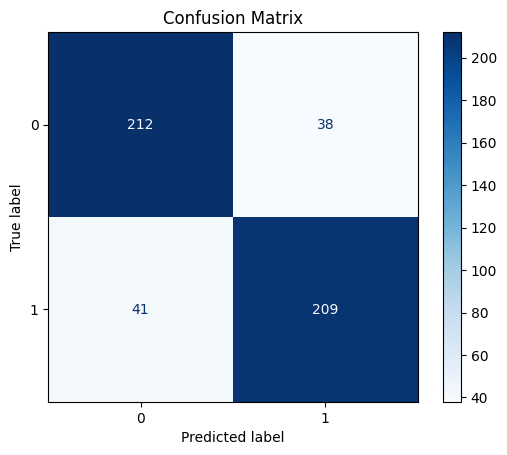

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 

In [8]:
train_path = 'data/train'
test_path = 'data/test'

train_dataset = SkinCancerDataset(train_path, transform=transform)
test_dataset = SkinCancerDataset(test_path, transform=transform)

model = EfficientNetEncoder().to(DEVICE)

train_few_shot(model, train_dataset, episodes=100)
evaluate_and_metrics(model, test_dataset, episodes=50)



Confusion Matrix:
 [[212  38]
 [ 52 198]]

Classification Report:

              precision    recall  f1-score   support

           0     0.8030    0.8480    0.8249       250
           1     0.8390    0.7920    0.8148       250

    accuracy                         0.8200       500
   macro avg     0.8210    0.8200    0.8199       500
weighted avg     0.8210    0.8200    0.8199       500

ROC AUC: 0.9216


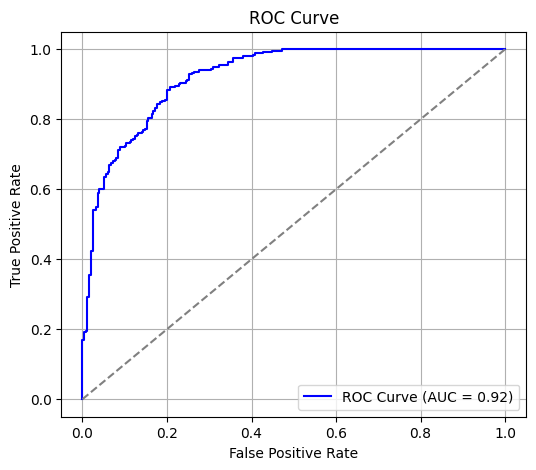

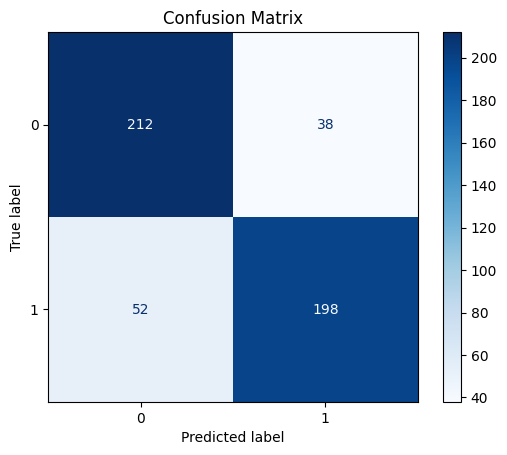

In [9]:
y_true, y_pred, y_prod = evaluate_and_metrics(model, test_dataset, episodes=50)

In [10]:
torch.save(model.state_dict(), 'classification_skin_cancer.pth')
print("✅ Model disimpan sebagai 'classification_skin_cancer.pth'")

✅ Model disimpan sebagai 'classification_skin_cancer.pth'
